In [156]:
import pandas as pd
import io
import datetime
from urllib.request import urlopen
import matplotlib.pyplot as plt
import plotly.express as px
from urllib import request
import json
import warnings
import numpy as np
import seaborn as sns
import uszipcode
from uszipcode import SearchEngine
import folium
from folium.plugins import HeatMap
from scipy.stats import pearsonr
import matplotlib.colors as mcolors
warnings.filterwarnings('ignore')

<h1 style="text-align: center;">UFO SIGHTINGS AND EDUCATION IN THE UNITED STATES NORMALIZED BY POPULATION AT THE COUNTY LEVEL</h1>


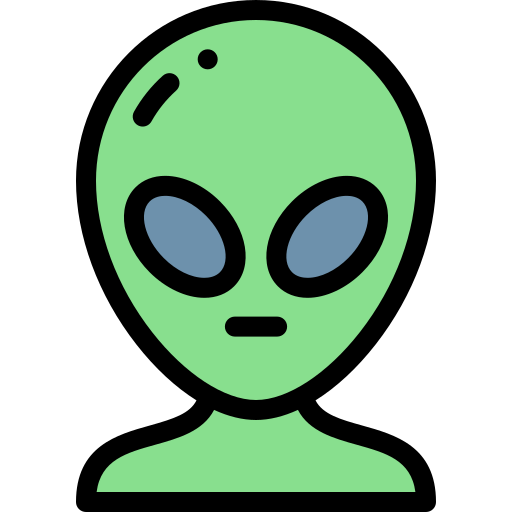

**By: Max Sohl (sohl@calpoly.edu), Harshal Suryawanshi (hsuryawa@calpoly.edu), and Kathleen Gendotti (kgendott@calpoly.edu)**

# Hypothesis:

### We anticipate that higher frequencies of reported UFO sightings in the United States are correlated with US counties that have less educated adults. We assume this, because education should provide people with the ability to accept that things they don't understand in the sky are likely to be experimental aircraft, stars, or whatever else.

# Import and Clean Alien Sightings Data

Data Source: https://mavenanalytics.io/data-playground?page=6&pageSize=5

### Filter data by year 2000

In [2]:
url = 'https://raw.githubusercontent.com/maxsohl/GSB521FinalProj/main/ufo_sightings_scrubbed.csv'
df = pd.read_csv(url)

In [3]:
us_df = df.loc[df["country"] == "us"]

In [147]:
us_df['datetime'] = pd.to_datetime(us_df['datetime']) #convert to datetime data type
us_df['date'] = us_df['datetime'].dt.date #seperate into two columns
us_df['time'] = us_df['datetime'].dt.time
pd.to_datetime(us_df['date'])
us_df['year'] = us_df['date'].apply(lambda x: x.strftime('%Y'))
us_df['year'] = us_df['year'].astype(int)
year_to_filter = 2000
us_df_2000 = us_df[us_df['year'] > year_to_filter]

# Import county dataset and merge with alien data so city names are matched with county names

Data Source: https://public.opendatasoft.com/explore/dataset/geonames-all-cities-with-a-population-1000/table/?disjunctive.cou_name_en&sort=name

In [149]:
url = 'https://raw.githubusercontent.com/maxsohl/GSB521FinalProj/main/city_county.csv'
city_county = pd.read_csv(url)

In [157]:
merged_df = pd.merge(us_df_2000, city_county, on= ['city','state'], how = 'left')
merged_df.dropna(subset=['county'], inplace=True)

# Import EducationByCounty and merge with df

Data Source:

In [7]:
url = 'https://raw.githubusercontent.com/maxsohl/GSB521FinalProj/main/EducationByCounty.csv'
education = pd.read_csv(url)

In [8]:
education['state'] = education['State'].str.lower()
education['county'] = education['Area name'].str.lower()

In [9]:
#to match merged_df with education add county after every county name in merged_df
def add_county(word):
    return f"{word} county"

merged_df['county'] = merged_df['county'].apply(add_county)

In [10]:
education_merged_df = pd.merge(merged_df, education, on= ['county','state'], how = 'left')

# Bring in fips number/ merge with educ data

In [158]:
url = 'https://raw.githubusercontent.com/maxsohl/GSB521FinalProj/main/fips2county.csv'
fips_to_county = pd.read_csv(url)
fips_to_county['county'] = fips_to_county['CountyName']
fips_to_county['state'] = fips_to_county['StateAbbr']
fips_to_county['fips'] = fips_to_county['CountyFIPS']
fips_to_county = fips_to_county.loc[:, ['county', 'state','fips']]

#### Merge fips_to_county with education_merged_df so can merge pop on fips

In [150]:
#Clean fips_to_county so it can be merged with education_merged_df
fips_to_county['county'] = fips_to_county['county'].str.lower()
fips_to_county['state'] = fips_to_county['state'].str.lower()

In [151]:
def add_county(word):
    return f"{word} county"

fips_to_county['county'] = fips_to_county['county'].apply(add_county)

In [16]:
#Merge fips and educ
education_merged_df_fips = pd.merge(education_merged_df, fips_to_county, on=['county','state'], how='left')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 100)

In [159]:
#convert education_merged_df_fips['fips'] from float to int
education_merged_df_fips = education_merged_df_fips.dropna(subset=['fips'])
education_merged_df_fips['fips'] = education_merged_df_fips['fips'].astype(int)

# Normalize number of sightings by county population

Source:https://www.ers.usda.gov/data-products/county-level-data-sets/county-level-data-sets-download-data/

### Here we import population data by county, merge the data with our education/ alien sighting data, count the number of sightings per county, and divide the number of sightings by population for normalization creating a new variable called "norm_count"

In [152]:
url = 'https://raw.githubusercontent.com/maxsohl/GSB521FinalProj/main/PopulationEstimates.csv'
pop_df = pd.read_csv(url)

In [153]:
pop_educ_alien_df = pd.merge(education_merged_df_fips, pop_df, on='fips', how='left')

In [67]:
county_count_df = pop_educ_alien_df.groupby(['fips']).size().reset_index(name='count')
county_count_df
county_count_merged_df = pd.merge(county_count_df, pop_educ_alien_df, on=['fips'], how='left')
county_count_merged_df
county_count_merged_df = county_count_merged_df.drop_duplicates(subset=['fips'])
county_count_merged_df['Population 2010'] = county_count_merged_df['Population 2010'].str.replace(',', '')
county_count_merged_df['Population 2010'] = county_count_merged_df['Population 2010'].astype(int)
county_count_merged_df['norm_count'] = (county_count_merged_df['count']/county_count_merged_df['Population 2010'])*100000
county_count_merged_df

,fips,count,datetime,city,state_x,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,date,time,year,county_x,Federal Information Processing Standard (FIPS) Code,State,Area name,2003 Rural-urban Continuum Code,2003 Urban Influence Code,2013 Rural-urban Continuum Code,2013 Urban Influence Code,"Less than a high school diploma, 1970","High school diploma only, 1970","Some college (1-3 years), 1970","Four years of college or higher, 1970","Percent of adults with less than a high school diploma, 1970","Percent of adults with a high school diploma only, 1970","Percent of adults completing some college (1-3 years), 1970","Percent of adults completing four years of college or higher, 1970","Less than a high school diploma, 1980","High school diploma only, 1980","Some college (1-3 years), 1980","Four years of college or higher, 1980","Percent of adults with less than a high school diploma, 1980","Percent of adults with a high school diploma only, 1980","Percent of adults completing some college (1-3 years), 1980","Percent of adults completing four years of college or higher, 1980","Less than a high school diploma, 1990","High school diploma only, 1990","Some college or associate's degree, 1990","Bachelor's degree or higher, 1990","Percent of adults with less than a high school diploma, 1990","Percent of adults with a high school diploma only, 1990","Percent of adults completing some college or associate's degree, 1990","Percent of adults with a bachelor's degree or higher, 1990","Less than a high school diploma, 2000","High school diploma only, 2000","Some college or associate's degree, 2000","Bachelor's degree or higher, 2000","Percent of adults with less than a high school diploma, 2000","Percent of adults with a high school diploma only, 2000","Percent of adults completing some college or associate's degree, 2000","Percent of adults with a bachelor's degree or higher, 2000","Less than a high school diploma, 2008-12","High school diploma only, 2008-12","Some college or associate's degree, 2008-12","Bachelor's degree or higher, 2008-12","Percent of adults with less than a high school diploma, 2008-12","Percent of adults with a high school diploma only, 2008-12","Percent of adults completing some college or associate's degree, 2008-12","Percent of adults with a bachelor's degree or higher, 2008-12","Less than a high school diploma, 2017-21","High school diploma only, 2017-21","Some college or associate's degree, 2017-21","Bachelor's degree or higher, 2017-21","Percent of adults with less than a high school diploma, 2017-21","Percent of adults with a high school diploma only, 2017-21","Percent of adults completing some college or associate's degree, 2017-21","Percent of adults with a bachelor's degree or higher, 2017-21",state_y,county_y,Rural-Urban Continuum Code 2013,Population 1990,Population 2000,Population 2010,Population 2020,Population 2021,norm_count
0,1001,4,2008-11-18 07:40:00,prattville,al,us,disk,10,8-10 seconds,I saw a bright reflection fairly low in the sk...,2009-01-10,32.4638889,-86.459722,2008-11-18,07:40:00,2008,autauga county,1001.0,AL,Autauga County,2.0,2.0,2.0,2.0,"6,611","3,757",933,767,54.8,31.1,7.7,6.4,"7,074","6,145","2,104","2,117",40.6,35.2,12.1,12.1,"6,252","6,671","4,912","3,026",30.0,32.0,23.5,14.5,"5,872","9,332","7,413","4,972",21.3,33.8,26.9,18.0,"5,232","11,874","10,409","7,629",14.9,33.8,29.6,21.7,"4,126","12,977","11,367","11,144",10.4,32.8,28.7,28.1,AL,Autauga County,2.0,"34,222","43,751",54571,"58,805","59,095",7.329900
4,1003,40,2007-10-11 20:30:00,gulf shores,al,us,disk,1800,30 min.,Brightly lighted Object appeared total of 6-8 ...,2007-11-28,30.2458333,-87.700833,2007-10-11,20:30:00,2007,baldwin county,1003.0,AL,Baldwin County,4.0,5.0,3.0,2.0,"18,726","8,426","2,334","2,038",59.4,26.7,7.4,6.5,"18,125","15,380","6,602","5,498",39.7,33.7,14.5,12.1,"17,309","20,544","15,900","10,870",26.8,31.8,24.6,16.8,"17,258","28,428","28,178","22,146",18.0,29.6,29.3,23.

# Geo heatmap of number of normalized number of sightings in each county

In [77]:
#Still need to change the colors, scope, etc
map = folium.Map(location=[37,-96], zoom_start=4)
heatmap = HeatMap(county_count_merged_df[['latitude', 'longitude ', 'norm_count']].values.tolist(), radius=12, max_val=240)
heatmap.add_to(map)
map

# Violin plot of educ relative to norm_count

<AxesSubplot: xlabel='norm_count'>

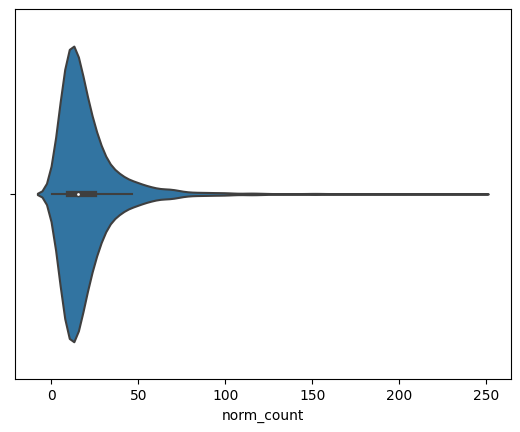

In [80]:
sns.violinplot(x=county_count_merged_df["norm_count"])

The median value for the norm count was on the lower end of the scale, around 25. Additionally the distribution for the norm count indicates that this data is skewed to the right, with most of the the norm count (number of UFO sightings, normalized) being highly concentrated around the median. 

<AxesSubplot: xlabel='Percent of adults with less than a high school diploma, 2008-12'>

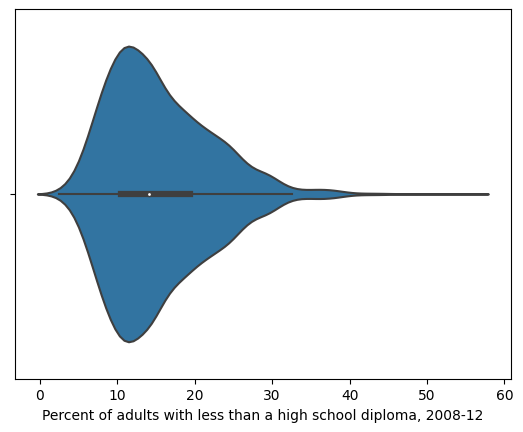

In [82]:
sns.violinplot(x=county_count_merged_df['Percent of adults with less than a high school diploma, 2008-12'])

Between 5% and 25% of adults with less than a high school diploma have high probability of spotting UFOs. Based on shape of distribution, the probability of sightings for this group is highly concentrated around the median (~15%).

<AxesSubplot: xlabel='Percent of adults with a high school diploma only, 2008-12'>

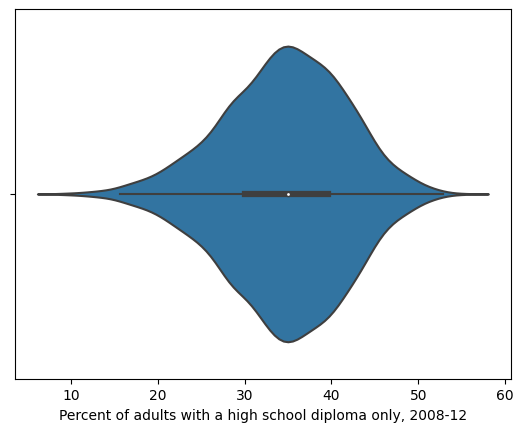

In [83]:
sns.violinplot(x=county_count_merged_df['Percent of adults with a high school diploma only, 2008-12'])

The distribution for adults with a high school diploma alone was more widely distributed those with the highest probability of spotting UFOs occuring between 25% and 45% of adults. 

<AxesSubplot: xlabel="Percent of adults completing some college or associate's degree, 2008-12">

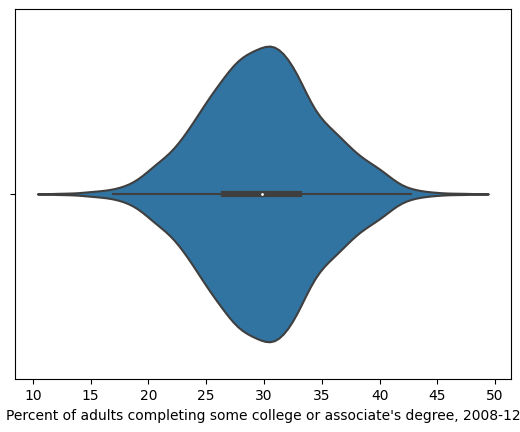

In [85]:
sns.violinplot(x=county_count_merged_df["Percent of adults completing some college or associate's degree, 2008-12"])

Very similar to the high school diploma only, the highest probability for UFO sightings for adults with some college or an associates degree is between about 25% and 45%

<AxesSubplot: xlabel="Percent of adults with a bachelor's degree or higher, 2008-12">

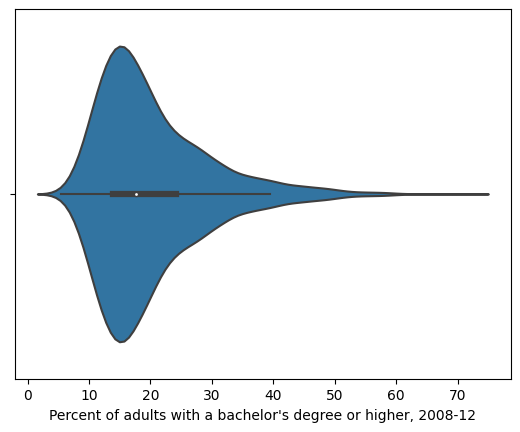

In [86]:
sns.violinplot(x=county_count_merged_df["Percent of adults with a bachelor's degree or higher, 2008-12"])

For those adults with a bachelor’s degree or higher, the highest probability of UFO sightings is narrower for only about between 10-20% of adults and with a smaller median (around 15%), similar to those with less than a high school diploma. 

# Box plot with jitter

### For our boxplots we created a new dummy variable "norm_count_mean" that marks "below" if the normalized number of alien sightings is below the mean and "above" if the normalized number of sightings is above the mean

In [93]:
avg_norm_count = county_count_merged_df['norm_count'].mean()
county_count_merged_df['norm_count_mean'] = county_count_merged_df['norm_count'].apply(lambda x: 'above' if x > avg_norm_count else 'below')
county_count_merged_df

,fips,count,datetime,city,state_x,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,date,time,year,county_x,Federal Information Processing Standard (FIPS) Code,State,Area name,2003 Rural-urban Continuum Code,2003 Urban Influence Code,2013 Rural-urban Continuum Code,2013 Urban Influence Code,"Less than a high school diploma, 1970","High school diploma only, 1970","Some college (1-3 years), 1970","Four years of college or higher, 1970","Percent of adults with less than a high school diploma, 1970","Percent of adults with a high school diploma only, 1970","Percent of adults completing some college (1-3 years), 1970","Percent of adults completing four years of college or higher, 1970","Less than a high school diploma, 1980","High school diploma only, 1980","Some college (1-3 years), 1980","Four years of college or higher, 1980","Percent of adults with less than a high school diploma, 1980","Percent of adults with a high school diploma only, 1980","Percent of adults completing some college (1-3 years), 1980","Percent of adults completing four years of college or higher, 1980","Less than a high school diploma, 1990","High school diploma only, 1990","Some college or associate's degree, 1990","Bachelor's degree or higher, 1990","Percent of adults with less than a high school diploma, 1990","Percent of adults with a high school diploma only, 1990","Percent of adults completing some college or associate's degree, 1990","Percent of adults with a bachelor's degree or higher, 1990","Less than a high school diploma, 2000","High school diploma only, 2000","Some college or associate's degree, 2000","Bachelor's degree or higher, 2000","Percent of adults with less than a high school diploma, 2000","Percent of adults with a high school diploma only, 2000","Percent of adults completing some college or associate's degree, 2000","Percent of adults with a bachelor's degree or higher, 2000","Less than a high school diploma, 2008-12","High school diploma only, 2008-12","Some college or associate's degree, 2008-12","Bachelor's degree or higher, 2008-12","Percent of adults with less than a high school diploma, 2008-12","Percent of adults with a high school diploma only, 2008-12","Percent of adults completing some college or associate's degree, 2008-12","Percent of adults with a bachelor's degree or higher, 2008-12","Less than a high school diploma, 2017-21","High school diploma only, 2017-21","Some college or associate's degree, 2017-21","Bachelor's degree or higher, 2017-21","Percent of adults with less than a high school diploma, 2017-21","Percent of adults with a high school diploma only, 2017-21","Percent of adults completing some college or associate's degree, 2017-21","Percent of adults with a bachelor's degree or higher, 2017-21",state_y,county_y,Rural-Urban Continuum Code 2013,Population 1990,Population 2000,Population 2010,Population 2020,Population 2021,norm_count,Above_Mean,norm_count_above_mean,norm_count_mean
0,1001,4,2008-11-18 07:40:00,prattville,al,us,disk,10,8-10 seconds,I saw a bright reflection fairly low in the sk...,2009-01-10,32.4638889,-86.459722,2008-11-18,07:40:00,2008,autauga county,1001.0,AL,Autauga County,2.0,2.0,2.0,2.0,"6,611","3,757",933,767,54.8,31.1,7.7,6.4,"7,074","6,145","2,104","2,117",40.6,35.2,12.1,12.1,"6,252","6,671","4,912","3,026",30.0,32.0,23.5,14.5,"5,872","9,332","7,413","4,972",21.3,33.8,26.9,18.0,"5,232","11,874","10,409","7,629",14.9,33.8,29.6,21.7,"4,126","12,977","11,367","11,144",10.4,32.8,28.7,28.1,AL,Autauga County,2.0,"34,222","43,751",54571,"58,805","59,095",7.329900,0,0,below
4,1003,40,2007-10-11 20:30:00,gulf shores,al,us,disk,1800,30 min.,Brightly lighted Object appeared total of 6-8 ...,2007-11-28,30.2458333,-87.700833,2007-10-11,20:30:00,2007,baldwin county,1003.0,AL,Baldwin County,4.0,5.0,3.0,2.0,"18,726","8,426","2,334","2,038",59.4,26.7,7.4,6.5,"18,125","15,380","6,602","5,498",39.7,33.7,14.5,12.1,"17,309","20,544","15,900","10,870",26.8,31.8,24.6,

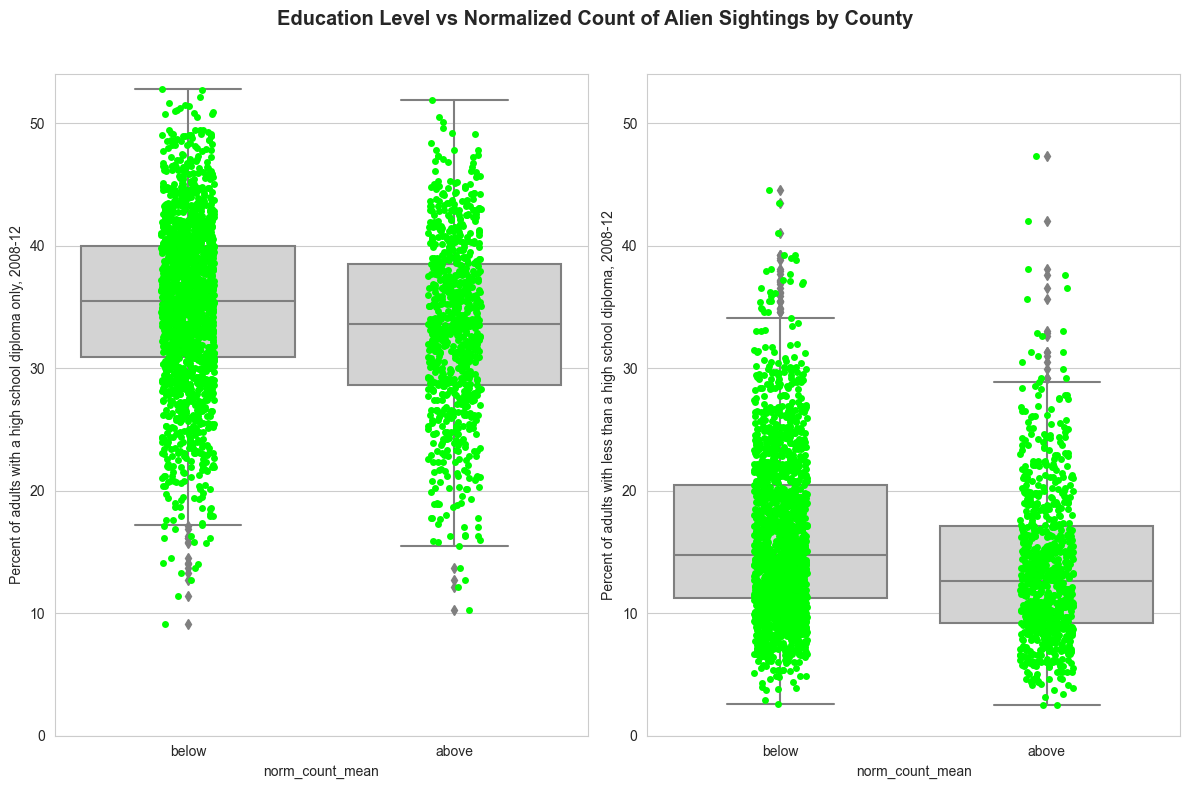

In [155]:
# figure size
fig, axes = plt.subplots(1, 2, figsize=(12, 8))

# boxplot 
sns.boxplot(x="norm_count_mean", y="Percent of adults with less than a high school diploma, 2008-12", data=county_count_merged_df, color="lightgray", ax=axes[1]).set_ylim(6,25)
sns.boxplot(x="norm_count_mean", y="Percent of adults with a high school diploma only, 2008-12", data=county_count_merged_df, color="lightgray", ax=axes[0]).set_ylim(6,25)


# setting color for jitter and grid 
colors = ["lime"]
sns.set_palette(colors)
sns.set_style("whitegrid")

# jitter plot / stripplot
sns.stripplot(x="norm_count_mean", y="Percent of adults with less than a high school diploma, 2008-12", data=county_count_merged_df, ax=axes[1]).set_ylim(0,54)
sns.stripplot(x="norm_count_mean", y="Percent of adults with a high school diploma only, 2008-12", data=county_count_merged_df, ax=axes[0]).set_ylim(0,54)


# showing the graph
fig.tight_layout()
fig.suptitle("Education Level vs Normalized Count of Alien Sightings by County", fontsize = 'x-large', fontweight = 'bold' )
fig.subplots_adjust(top = 0.9)
plt.show()

Here you can see that there is a higher percentage of adults with a highschool diploma only in norm_count_mean = below meaning the number of sightings for those who fall in this education bracket is more likely to be below the mean. For the percentage of adults with less than a highschool diplomat this also remains true. 

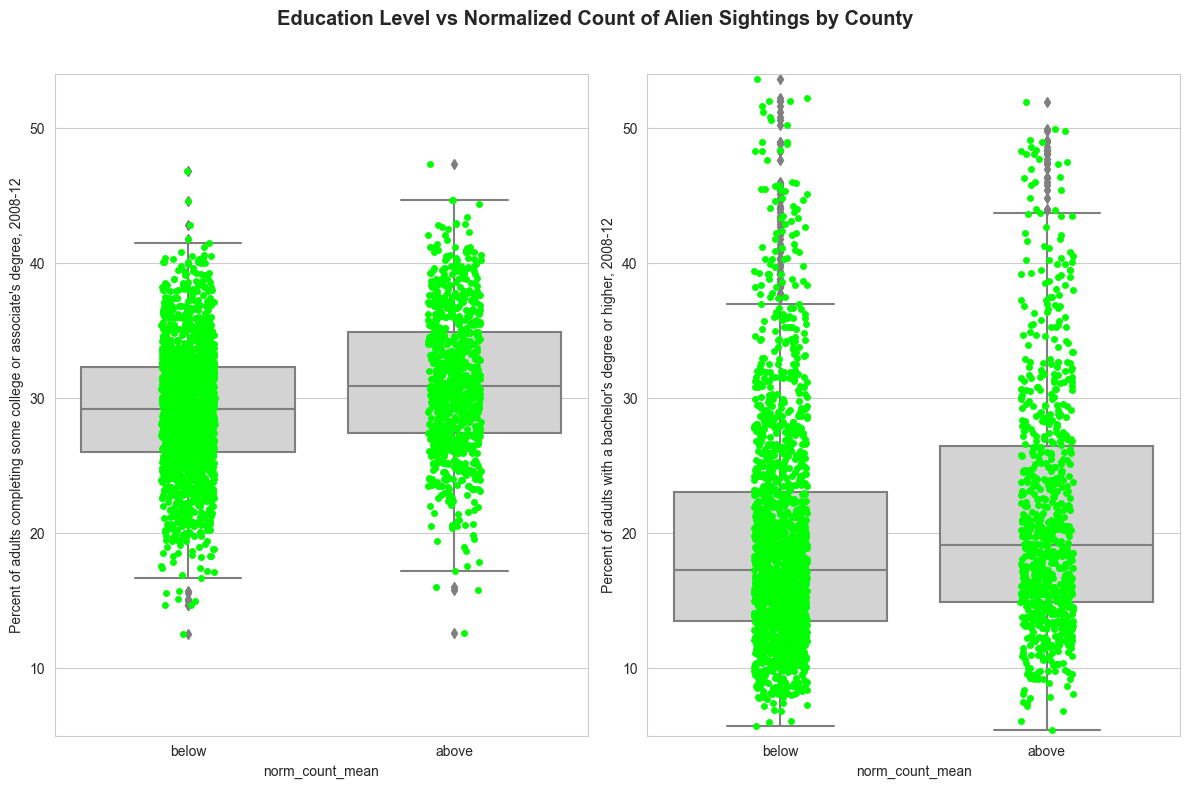

In [154]:
# figure size
fig, axes = plt.subplots(1, 2, figsize=(12, 8))

# boxplot 
sns.boxplot(x="norm_count_mean", y="Percent of adults completing some college or associate's degree, 2008-12", data=county_count_merged_df, color="lightgray", ax=axes[0]).set_ylim(6,25)
sns.boxplot(x="norm_count_mean", y="Percent of adults with a bachelor's degree or higher, 2008-12", data=county_count_merged_df, color="lightgray", ax=axes[1]).set_ylim(6,25)


# setting color for jitter and grid 
colors = ["lime"]
sns.set_palette(colors)
sns.set_style("whitegrid")

# jitter plot / stripplot
sns.stripplot(x="norm_count_mean", y="Percent of adults completing some college or associate's degree, 2008-12", data=county_count_merged_df, ax=axes[0]).set_ylim(5,54)
sns.stripplot(x="norm_count_mean", y="Percent of adults with a bachelor's degree or higher, 2008-12", data=county_count_merged_df, ax=axes[1]).set_ylim(5,54)


# showing the graph
fig.tight_layout()
fig.suptitle("Education Level vs Normalized Count of Alien Sightings by County", fontsize = 'x-large', fontweight = 'bold' )
fig.subplots_adjust(top = 0.9)
plt.show()

Here you can see that there is a higher percentage of adults with some college or assosciates degree in norm_count_mean = above meaning the number of sightings for those who fall in this education bracket is more likely to be above the mean. For the percentage of adults with a bachelors degree or higher this also remains true. 

This shows that one would expect the two higher education brackets to produce norm_count_mean = above vs. the two lower education brackets that produced norm_count_mean = below. This shows contrary to our hypothesis that a higher number of alien sightings is likely correlated with counties that have a higher percentage of educated adults. 

# Person's correlation

In [130]:
from scipy.stats import pearsonr

county_count_merged_df = county_count_merged_df.dropna(subset=['norm_count'])
county_count_merged_df = county_count_merged_df.dropna(subset=['Percent of adults with less than a high school diploma, 2008-12'])


# Convert dataframe into series
list1 = county_count_merged_df['norm_count']
list2 = county_count_merged_df['Percent of adults with less than a high school diploma, 2008-12']

# Apply the pearsonr()
corr, _ = pearsonr(list1, list2)
corr1 = corr

Pearsons correlation: -0.164


In [131]:
# Convert dataframe into series
list1 = county_count_merged_df['norm_count']
list2 = county_count_merged_df['Percent of adults with a high school diploma only, 2008-12']

# Apply the pearsonr()
corr, _ = pearsonr(list1, list2)
corr2 = corr

Pearsons correlation: -0.119


In [132]:
# Convert dataframe into series
list1 = county_count_merged_df['norm_count']
list2 = county_count_merged_df["Percent of adults completing some college or associate's degree, 2008-12"]

# Apply the pearsonr()
corr, _ = pearsonr(list1, list2)
corr3 = corr

Pearsons correlation: 0.214


In [133]:
# Convert dataframe into series
list1 = county_count_merged_df['norm_count']
list2 = county_count_merged_df["Percent of adults with a bachelor's degree or higher, 2008-12"]

# Apply the pearsonr()
corr, _ = pearsonr(list1, list2)
corr4 = corr

Pearsons correlation: 0.096


In [139]:
import pandas as pd

data = {"Pearson's Correlation": [corr1, corr2, corr3, corr4]}

df = pd.DataFrame(data, index=["Percent of adults with less than a high school diploma, 2008-12",
                               "Percent of adults with a high school diploma only, 2008-12",
                               "Percent of adults completing some college or associate's degree, 2008-12",
                               "Percent of adults with a bachelor's degree or higher, 2008-12"])

df

,Pearson's Correlation
"Percent of adults with less than a high school diploma, 2008-12",-0.163795
"Percent of adults with a high school diploma only, 2008-12",-0.119032
"Percent of adults completing some college or associate's degree, 2008-12",0.214229
"Percent of adults with a bachelor's degree or higher, 2008-12",0.096005


Pearson’s correlation coefficient for People with less than a high school diploma and people with just diploma have a negative correlation which means that these people fall in the category of not sighting UFOs. While the other category which has people who have higher education had a positive correlation which means these people have higher tendency of sighting a UFO.

# Conclusion:

### Based on our analysis, we can conclude that our hypothesis of higher frequencies of reported UFO sightings in the United States counties having less educated adults is not supported.  In fact, there is a negative correlation between the percent of adults with a high school diploma or less with UFO sightings. We found there is a positive correlation between adults with higher levels or education and UFO sightings. Thus, we can conclude that adults with higher levels of education (more than a high school diploma) are more likely to see and report UFO sightings in the United States. 